# Start

In [13]:
# Install Hugging Face + PyTorch dependencies (run once per fresh runtime)
%pip install -q transformers datasets accelerate torch emoji


Note: you may need to restart the kernel to use updated packages.


In [14]:

# START

import os
import re
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import transformers
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

import mlflow
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc,
)

MLFLOW_EXPERIMENT_NAME = "Model_BERTweet"
MODEL_NAME = "vinai/bertweet-base"
MAX_LENGTH = 128
BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 2e-5
MAX_TRAIN_SAMPLES = 6000  # down-sample training split for faster epochs

mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

print("Transformers version:", transformers.__version__)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Transformers version: 4.57.1
PyTorch version: 2.9.1+cu128
CUDA available: True


# DATA READING

In [15]:
# DATA READING
df = pd.read_csv(
    "../../sentiment140/training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    header=None,
    names=["sentiment", "id", "date", "query", "user", "tweet"],
)

df.head()

,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [16]:
# Keep only sentiment + tweet

df = df[["sentiment", "tweet"]]

# Stratified sampling to have tweets of the two sentiments
df_negatifs = df[df["sentiment"] == 0].sample(8000, random_state=42)
df_positifs = df[df["sentiment"] == 4].sample(8000, random_state=42)

# So we get a sample of 10% of the original dataset
df = pd.concat([df_negatifs, df_positifs]).reset_index(drop=True)

# Map labels 4 -> 1 for binary classification
df["sentiment"] = df["sentiment"].replace(4, 1)

df.head()


,sentiment,tweet
0,0,@xnausikaax oh no! where did u order from? tha...
1,0,A great hard training weekend is over. a coup...
2,0,"Right, off to work Only 5 hours to go until I..."
3,0,I am craving for japanese food
4,0,Jean Michel Jarre concert tomorrow gotta work...


In [17]:
# Class balance check
df["sentiment"].value_counts()


sentiment
0    8000
1    8000
Name: count, dtype: int64

# CLEANING TEXT

## Preprocessing

✅ Preprocessing steps(preparing for TF-IDF + Logistic Regression)

Compared to the preprocessing of tweets made during the application of logistic regression, the steps written in red have been removed, and the steps in green are repeated or added for this time.


<span style="color:red">- Lowercase</span>

<span style="color:red">- Convert emoticons → words</span>

<span style="color:red">- Convert emojis → words</span>

<span style="color:red">- Remove URLs, mentions, hashtags</span>


In [18]:
# CLEANING TEXT – passthrough (only whitespace trimming)

def normalize_tweet(t: str) -> str:
    return re.sub(r"\s+", " ", t.strip())


## Spliting

In [19]:
# Spliting – same logic as in Model 2

texts = df["tweet"].astype(str).tolist()
labels = df["sentiment"].astype("float32").to_numpy()

X_train, X_tmp, y_train, y_tmp = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.5,
    random_state=42,
    stratify=y_tmp,
)

print("Train size:", len(X_train), "Val size:", len(X_val), "Test size:", len(X_test))


Train size: 12800 Val size: 1600 Test size: 1600


In [20]:
# Normalize tweets after splitting to avoid leakage

def _normalize_batch(texts: List[str]) -> List[str]:
    return [normalize_tweet(t) for t in texts]

X_train_clean = _normalize_batch(X_train)
X_val_clean = _normalize_batch(X_val)
X_test_clean = _normalize_batch(X_test)

y_train_int = y_train.astype(int)
y_val_int = y_val.astype(int)
y_test_int = y_test.astype(int)


In [21]:
# Convert splits to Hugging Face Dataset objects

train_dataset = Dataset.from_dict({"text": X_train_clean, "label": y_train_int})
val_dataset = Dataset.from_dict({"text": X_val_clean, "label": y_val_int})
test_dataset = Dataset.from_dict({"text": X_test_clean, "label": y_test_int})

train_dataset


Dataset({
    features: ['text', 'label'],
    num_rows: 12800
})

In [22]:
# Tokenization with BERTweet tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    normalization=True,
    use_fast=False,
)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )

tokenized_train = train_dataset.map(tokenize_batch, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_batch, batched=True, remove_columns=["text"])
tokenized_test = test_dataset.map(tokenize_batch, batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")


Map: 100%|██████████| 1600/1600 [00:00<00:00, 5298.01 examples/s]


In [23]:

# Optional: down-sample training set for faster epochs

training_dataset = tokenized_train
if MAX_TRAIN_SAMPLES and MAX_TRAIN_SAMPLES < len(tokenized_train):
    training_dataset = tokenized_train.shuffle(seed=42).select(range(MAX_TRAIN_SAMPLES))
    print(f"Using {len(training_dataset)} / {len(tokenized_train)} training samples for speed")
else:
    print(f"Using all {len(tokenized_train)} training samples")


Using 6000 / 12800 training samples for speed


In [24]:

# Fine-tune vinai/bertweet-base with the Trainer API

import inspect

TRAINING_ARGS_PARAMS = set(inspect.signature(TrainingArguments.__init__).parameters.keys())

def _add_if_supported(kwargs, name, value):
    if name in TRAINING_ARGS_PARAMS:
        kwargs[name] = value
        return True
    return False


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

training_kwargs = {"output_dir": "./bertweet_outputs"}
_add_if_supported(training_kwargs, "learning_rate", LEARNING_RATE)
_add_if_supported(training_kwargs, "num_train_epochs", EPOCHS)
_add_if_supported(training_kwargs, "weight_decay", 0.01)
_add_if_supported(training_kwargs, "logging_steps", 50)
_add_if_supported(training_kwargs, "seed", 42)

if not _add_if_supported(training_kwargs, "per_device_train_batch_size", BATCH_SIZE):
    _add_if_supported(training_kwargs, "per_gpu_train_batch_size", BATCH_SIZE)
if not _add_if_supported(training_kwargs, "per_device_eval_batch_size", BATCH_SIZE):
    _add_if_supported(training_kwargs, "per_gpu_eval_batch_size", BATCH_SIZE)

steps_per_epoch = max(len(training_dataset) // BATCH_SIZE, 1)
warmup_steps = int(0.1 * steps_per_epoch * EPOCHS)

if not _add_if_supported(training_kwargs, "warmup_ratio", 0.1):
    _add_if_supported(training_kwargs, "warmup_steps", warmup_steps)

has_eval_strategy = _add_if_supported(training_kwargs, "evaluation_strategy", "epoch")
if not has_eval_strategy:
    _add_if_supported(training_kwargs, "eval_steps", steps_per_epoch)

has_save_strategy = _add_if_supported(training_kwargs, "save_strategy", "epoch")
if not has_save_strategy:
    _add_if_supported(training_kwargs, "save_steps", steps_per_epoch)

if has_eval_strategy and not has_save_strategy:
    # make sure evaluation/saving align
    _add_if_supported(training_kwargs, "save_strategy", training_kwargs.get("evaluation_strategy", "steps"))

has_load_best = _add_if_supported(training_kwargs, "load_best_model_at_end", True)
if has_load_best and not has_eval_strategy:
    # load_best requires evaluation
    training_kwargs.pop("load_best_model_at_end", None)

_add_if_supported(training_kwargs, "metric_for_best_model", "f1")
_add_if_supported(training_kwargs, "report_to", [])

training_args = TrainingArguments(**training_kwargs)

with mlflow.start_run(run_name="bertweet-base"):
    mlflow.log_params(
        {
            "model_name": MODEL_NAME,
            "max_length": MAX_LENGTH,
            "learning_rate": LEARNING_RATE,
            "epochs": EPOCHS,
            "train_batch_size": BATCH_SIZE,
        }
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=training_dataset,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    train_result = trainer.train()
    mlflow.log_metric("train_loss", train_result.training_loss)

    val_metrics = trainer.evaluate(tokenized_val)
    mlflow.log_metrics(
        {
            "val_loss": val_metrics.get("eval_loss"),
            "val_accuracy": val_metrics.get("eval_accuracy"),
            "val_precision": val_metrics.get("eval_precision"),
            "val_recall": val_metrics.get("eval_recall"),
            "val_f1": val_metrics.get("eval_f1"),
        }
    )

    test_metrics = trainer.evaluate(tokenized_test)
    mlflow.log_metrics(
        {
            "test_loss": test_metrics.get("eval_loss"),
            "test_accuracy": test_metrics.get("eval_accuracy"),
            "test_precision": test_metrics.get("eval_precision"),
            "test_recall": test_metrics.get("eval_recall"),
            "test_f1": test_metrics.get("eval_f1"),
        }
    )

trainer


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_886/391449782.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.694000
100,0.679600
150,0.626500
200,0.484700
250,0.536400
300,0.469800
350,0.423300
400,0.428200
450,0.488600
500,0.392000


Test accuracy: 0.8469
Test precision: 0.8637
Test recall: 0.8237
Test F1-score: 0.8433


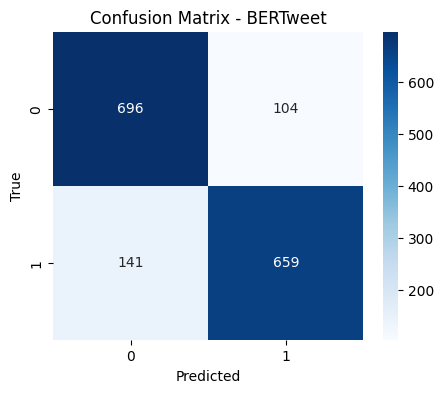

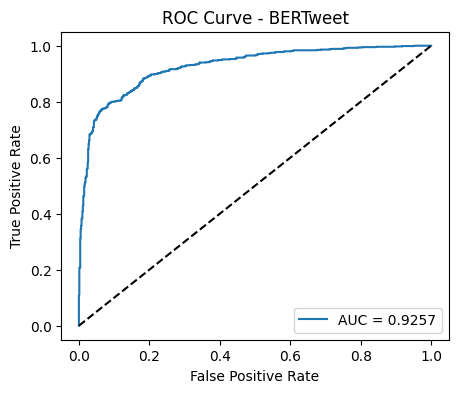

In [25]:
# Detailed test evaluation and visualizations

test_predictions = trainer.predict(tokenized_test)
y_true = test_predictions.label_ids
y_pred = np.argmax(test_predictions.predictions, axis=1)

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
acc = accuracy_score(y_true, y_pred)
print(f"Test accuracy: {acc:.4f}")
print(f"Test precision: {precision:.4f}")
print(f"Test recall: {recall:.4f}")
print(f"Test F1-score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - BERTweet")
plt.show()

probs = F.softmax(torch.from_numpy(test_predictions.predictions), dim=1).numpy()
fpr, tpr, _ = roc_curve(y_true, probs[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - BERTweet")
plt.legend(loc="lower right")
plt.show()
